# Goal:-

The goal is to create a language agnostic knowledge graph and a generic ontology from text. using only 1 document collection and 1 edge collection

# index:

1. read the data and upload kg data to arangodb
2. translate final_kg
3. read the data and upload ontology data to arangodb
4. translate ontology

In [2]:
import pandas as pd
import numpy as np
from arango import ArangoClient
import requests
from googletrans import Translator
from transformers import pipeline
from transformers import AutoTokenizer

In [3]:
# -------------------------------------------------------------------------------------------
# 1. read the kg data and upload to arangodb

text1 = '''
John is a 32-year-old software engineer with a master's degree in Computer Science. 
He's known for exceptional problem-solving skills, 
creative programming, and a friendly, approachable nature. 
With eight years of experience, he's a motivated team player and a strong leader in tech projects. 
Outside of work, John enjoys hiking, playing soccer, and staying active. '''

text2 = '''
jhon works in xyz corporation this corporation is located in india. 
which has a net worth of 5 billion dollars and has 3000 employees.
this company is a multinational company.

'''

In [4]:
# kg_data extracted using large language models in dataframe format

text1_knowledge_graph = [
    ("John", "is a", "software engineer"),
    ("John", "has", "32-year-old"),
    ("John", "has", "master's degree in Computer Science"),
    ("John", "is known for", "exceptional problem-solving skills"),
    ("John", "is known for", "creative programming"),
    ("John", "is known for", "friendly, approachable nature"),
    ("John", "has", "eight years of experience"),
    ("John", "is", "a motivated team player and a strong leader in tech projects"),
    ("John", "enjoys", "hiking"),
    ("John", "enjoys", "playing soccer"),
    ("John", "enjoys", "staying active")
]

text1_knowledge_graph_df = pd.DataFrame(text1_knowledge_graph, columns=["Subject", "Predicate", "Object"])

text2_knowledge_graph = [
    ("John", "works in", "XYZ Corporation"),
    ("XYZ Corporation", "is located in", "India"),
    ("XYZ Corporation", "has a net worth of", "5 billion dollars"),
    ("XYZ Corporation", "has", "3000 employees"),
    ("XYZ Corporation", "is a", "Multinational company")
]
text2_knowledge_graph_df = pd.DataFrame(text2_knowledge_graph, columns=["Subject", "Predicate", "Object"])

# ------------------------------------------------------------------------------------------------------------------------------
# ontology data extracted using large language models

text1_ontology_using_NER = data = [
    ("Person", "is a", "Profession"),
    ("Person", "has", "Age"),
    ("Person", "has", "Education"),
    ("Person", "is known for", "Skill"),
    ("Person", "is known for", "Skill"),
    ("Person", "is known for", "Personality Trait"),
    ("Person", "has", "Experience"),
    ("Person", "is", "Personality Trait"),
    ("Person", "enjoys", "Hobby"),
    ("Person", "enjoys", "Hobby"),
    ("Person", "enjoys", "Hobby")
]
text1_ontology_using_NER_df = pd.DataFrame(text1_ontology_using_NER, columns=["Subject_Type", "Predicate", "Object_Type"])

text2_ontology_using_NER = [
    ("Person", "works in", "Company"),
    ("Company", "is located in", "Location"),
    ("Company", "has a net worth of", "Monetary Value"),
    ("Company", "has", "Quantity"),
    ("Company", "is a", "Company Type")
]

text2_ontology_using_NER_df = pd.DataFrame(text2_ontology_using_NER, columns=["Subject_Type", "Predicate", "Object_Type"])

In [5]:
final_kg = pd.concat([text1_knowledge_graph_df, text2_knowledge_graph_df]).drop_duplicates().reset_index().drop(columns=["index"])
final_kg

,Subject,Predicate,Object
0,John,is a,software engineer
1,John,has,32-year-old
2,John,has,master's degree in Computer Science
3,John,is known for,exceptional problem-solving skills
4,John,is known for,creative programming
5,John,is known for,"friendly, approachable nature"
6,John,has,eight years of experience
7,John,is,a motivated team player and a strong leader in...
8,John,enjoys,hiking
9,John,enjoys,playing soccer


In [8]:
# uploading the ontology on arangodb

client = ArangoClient(hosts="http://localhost:8529/")
sys_db = client.db("_system", username="root", password="")

# sys_db.create_database("ontology_generator_optimized")

ontology_database = client.db(name="ontology_generator_optimized", username="root", password="")

In [9]:
ontology_database.create_collection("entities_kg")
entities_kg_coll = ontology_database.collection("entities_kg")

ontology_database.create_collection("relations_kg", edge=True)
relations_kg_coll = ontology_database.collection("relations_kg")

# ontology_database.delete_collection("entities_kg")
# ontology_database.delete_collection("relations_kg")

In [46]:
# uploading the data into the collections 

entities_dict = {}
entity_count = 0

# there are 2 columns subject and object in final_kg which has the entites uploading those and putting it in the dictionary
for i in final_kg["Subject"].unique():

    if i not in entities_dict:
        entities_dict[i] = entity_count
        entities_kg_coll.insert({'english':i,"rep_num":entity_count})
        entity_count += 1

for i in final_kg["Object"].unique():

    if i not in entities_dict:
        entities_dict[i] = entity_count
        entities_kg_coll.insert({'english':i,"rep_num":entity_count})
        entity_count += 1

entities_dict

{'John': 0,
 'XYZ Corporation': 1,
 'software engineer': 2,
 '32-year-old': 3,
 "master's degree in Computer Science": 4,
 'exceptional problem-solving skills': 5,
 'creative programming': 6,
 'friendly, approachable nature': 7,
 'eight years of experience': 8,
 'a motivated team player and a strong leader in tech projects': 9,
 'hiking': 10,
 'playing soccer': 11,
 'staying active': 12,
 'India': 13,
 '5 billion dollars': 14,
 '3000 employees': 15,
 'Multinational company': 16}

In [10]:
for i in entities_kg_coll:
    final_kg.replace(i["english"], i["_id"], inplace=True)

final_kg

,Subject,Predicate,Object
0,entities_kg/3115639,is a,entities_kg/3115643
1,entities_kg/3115639,has,entities_kg/3115645
2,entities_kg/3115639,has,entities_kg/3115647
3,entities_kg/3115639,is known for,entities_kg/3115649
4,entities_kg/3115639,is known for,entities_kg/3115651
5,entities_kg/3115639,is known for,entities_kg/3115653
6,entities_kg/3115639,has,entities_kg/3115655
7,entities_kg/3115639,is,entities_kg/3115657
8,entities_kg/3115639,enjoys,entities_kg/3115659
9,entities_kg/3115639,enjoys,entities_kg/3115661


In [64]:
predicate_dict = {}
predicate_count = 100

for i in range(final_kg.__len__()):

    if final_kg.loc[i]["Predicate"] not in predicate_dict:

        relations_kg_coll.insert({"_from":final_kg.loc[i]["Subject"],
                                "_to":final_kg.loc[i]["Object"],
                                "english":final_kg.loc[i]["Predicate"],
                                "rep_num":predicate_count})
    
        predicate_dict[final_kg.loc[i]["Predicate"]] = predicate_count
        predicate_count += 1

    elif final_kg.loc[i]["Predicate"] in predicate_dict:

        relations_kg_coll.insert({"_from":final_kg.loc[i]["Subject"],
                        "_to":final_kg.loc[i]["Object"],
                        "english":final_kg.loc[i]["Predicate"],
                        "rep_num":predicate_dict[final_kg.loc[i]["Predicate"]]})


predicate_dict

{'is a': 100,
 'has': 101,
 'is known for': 102,
 'is': 103,
 'enjoys': 104,
 'works in': 105,
 'is located in': 106,
 'has a net worth of': 107}

# The final_kg formed:
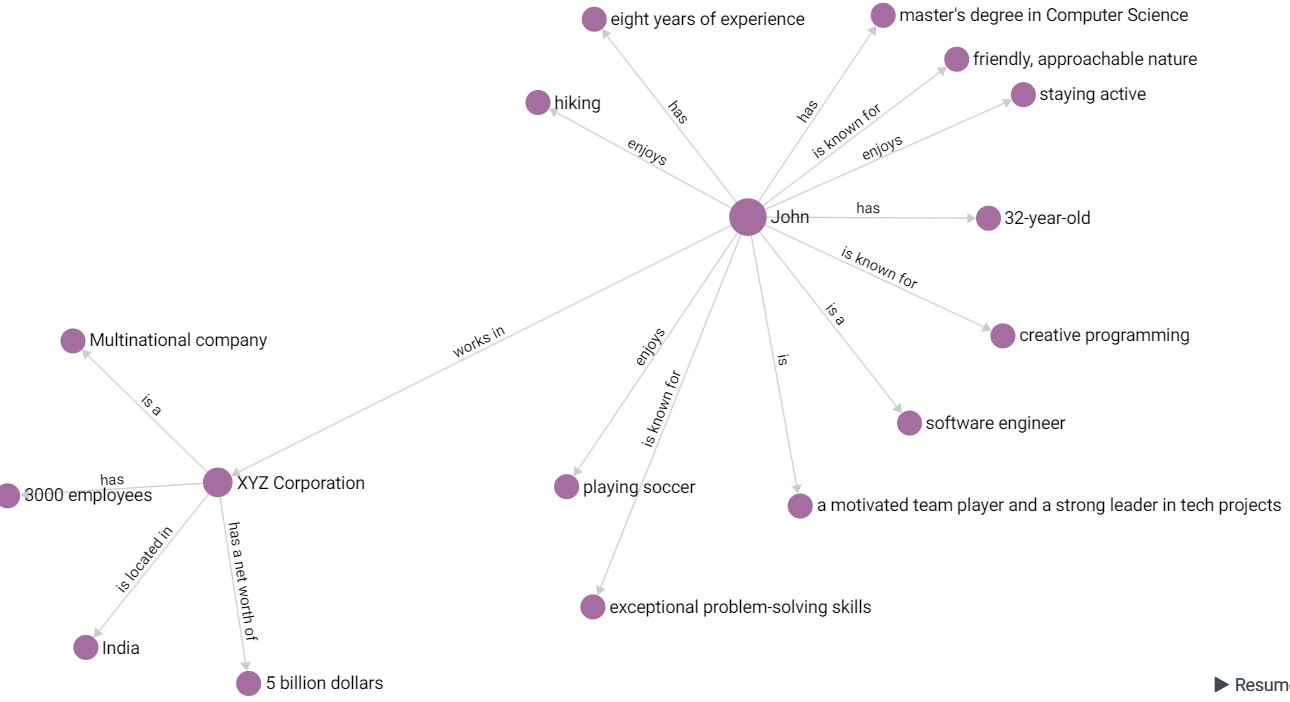
# The final_kg in number:
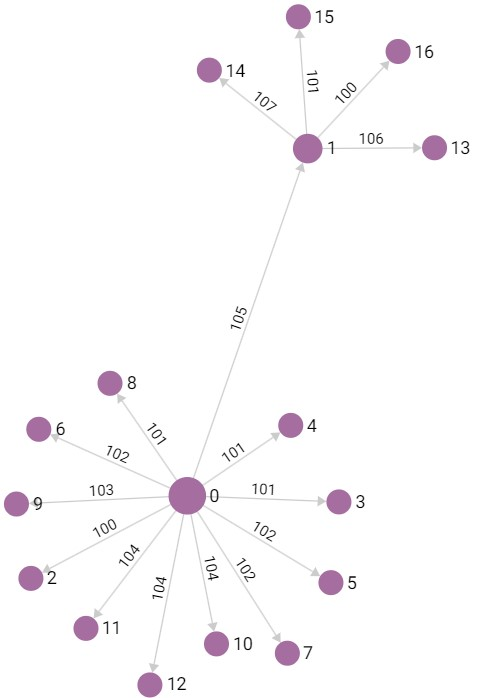

In [29]:
def translate_kg(lang_name, lang_code):
    
    translator = Translator()

    # nodes
    for i in entities_kg_coll:
        translated_response = translator.translate(i["english"], dest=lang_code).text
        entities_kg_coll.update({"_key":i["_key"], lang_name:translated_response})

    # edges
    for i in relations_kg_coll:
        translated_response = translator.translate(i["english"], dest=lang_code).text
        relations_kg_coll.update({"_key":i["_key"], lang_name:translated_response})

In [16]:
translate_kg("hindi","hi")
translate_kg("Japanese","ja")

# final_kg in hindi:
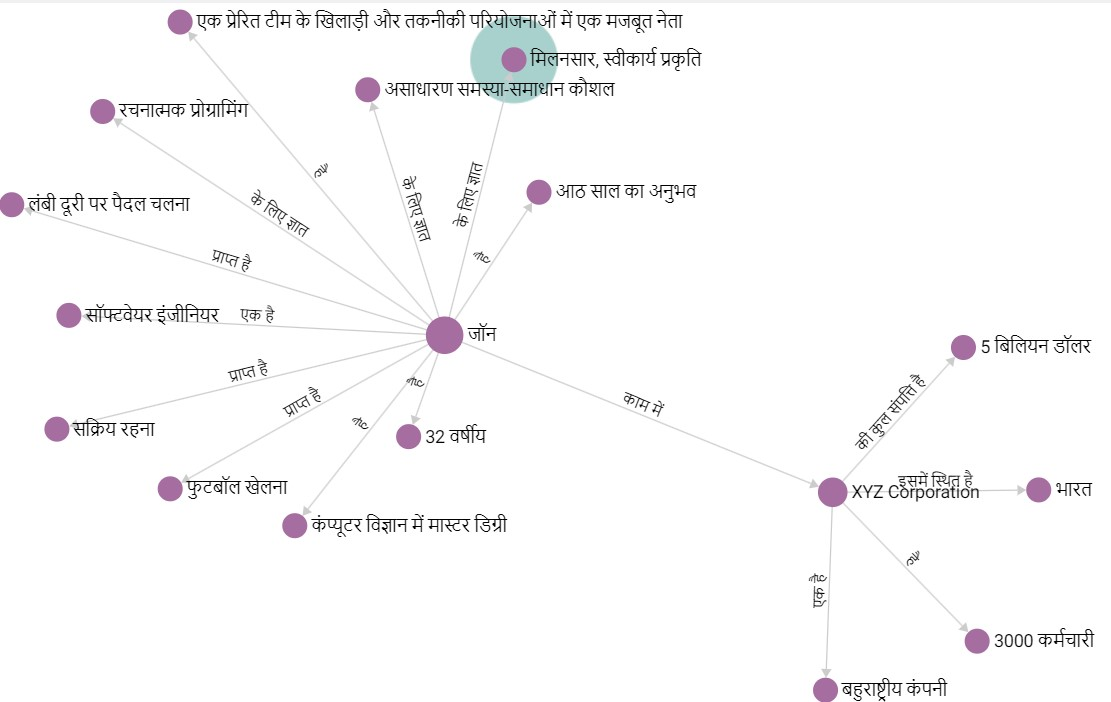
# final_kg in japanese:
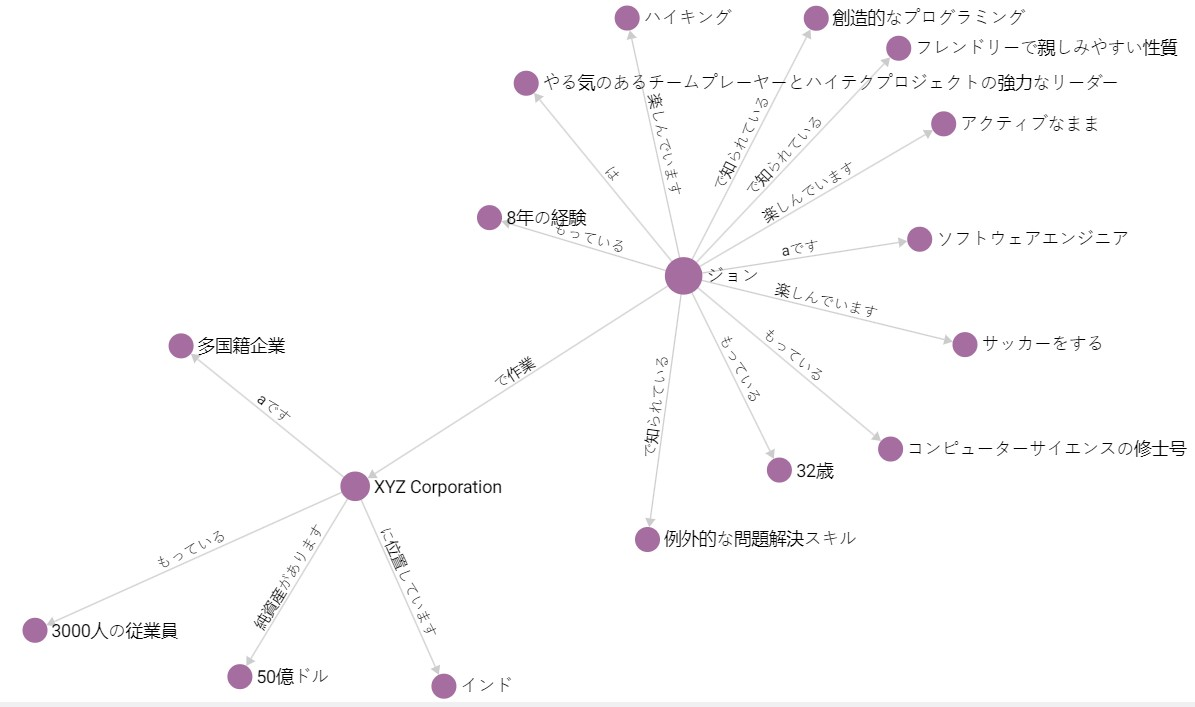

In [19]:
final_ontology = pd.concat([text1_ontology_using_NER_df,text2_ontology_using_NER_df]).drop_duplicates().reset_index().drop(columns=["index"])
final_ontology

,Subject_Type,Predicate,Object_Type
0,Person,is a,Profession
1,Person,has,Age
2,Person,has,Education
3,Person,is known for,Skill
4,Person,is known for,Personality Trait
5,Person,has,Experience
6,Person,is,Personality Trait
7,Person,enjoys,Hobby
8,Person,works in,Company
9,Company,is located in,Location


In [ ]:
ontology_database.create_collection("entities_onto")
entities_onto_coll = ontology_database.collection("entities_onto")

ontology_database.create_collection("relations_onto", edge=True)
relations_onto_coll = ontology_database.collection("relations_onto")

# ontology_database.delete_collection("entities_onto")
# ontology_database.delete_collection("relations_onto")

In [22]:
# uploading the data into the collections 

entities_dict_onto = {}
entity_count = 0

# there are 2 columns subject and object in final_kg which has the entites uploading those and putting it in the dictionary
for i in final_ontology["Subject_Type"].unique():

    if i not in entities_dict_onto:
        entities_dict_onto[i] = entity_count
        entities_onto_coll.insert({'english':i,"rep_num":entity_count})
        entity_count += 1

for i in final_ontology["Object_Type"].unique():

    if i not in entities_dict_onto:
        entities_dict_onto[i] = entity_count
        entities_onto_coll.insert({'english':i,"rep_num":entity_count})
        entity_count += 1

entities_dict_onto

{'Person': 0,
 'Company': 1,
 'Profession': 2,
 'Age': 3,
 'Education': 4,
 'Skill': 5,
 'Personality Trait': 6,
 'Experience': 7,
 'Hobby': 8,
 'Location': 9,
 'Monetary Value': 10,
 'Quantity': 11,
 'Company Type': 12}

In [25]:
for i in entities_onto_coll:
    final_ontology.replace(i["english"], i["_id"], inplace=True)

final_ontology

,Subject_Type,Predicate,Object_Type
0,entities_onto/3117100,is a,entities_onto/3117104
1,entities_onto/3117100,has,entities_onto/3117106
2,entities_onto/3117100,has,entities_onto/3117108
3,entities_onto/3117100,is known for,entities_onto/3117110
4,entities_onto/3117100,is known for,entities_onto/3117112
5,entities_onto/3117100,has,entities_onto/3117114
6,entities_onto/3117100,is,entities_onto/3117112
7,entities_onto/3117100,enjoys,entities_onto/3117116
8,entities_onto/3117100,works in,entities_onto/3117102
9,entities_onto/3117102,is located in,entities_onto/3117118


In [26]:
predicate_dict_onto = {}
predicate_count = 100

for i in range(final_ontology.__len__()):

    if final_ontology.loc[i]["Predicate"] not in predicate_dict_onto:

        relations_onto_coll.insert({"_from":final_ontology.loc[i]["Subject_Type"],
                                "_to":final_ontology.loc[i]["Object_Type"],
                                "english":final_ontology.loc[i]["Predicate"],
                                "rep_num":predicate_count})
    
        predicate_dict_onto[final_ontology.loc[i]["Predicate"]] = predicate_count
        predicate_count += 1

    elif final_ontology.loc[i]["Predicate"] in predicate_dict_onto:

        relations_onto_coll.insert({"_from":final_ontology.loc[i]["Subject_Type"],
                        "_to":final_ontology.loc[i]["Object_Type"],
                        "english":final_ontology.loc[i]["Predicate"],
                        "rep_num":predicate_dict_onto[final_ontology.loc[i]["Predicate"]]})


predicate_dict_onto

{'is a': 100,
 'has': 101,
 'is known for': 102,
 'is': 103,
 'enjoys': 104,
 'works in': 105,
 'is located in': 106,
 'has a net worth of': 107}

# final_ontology:
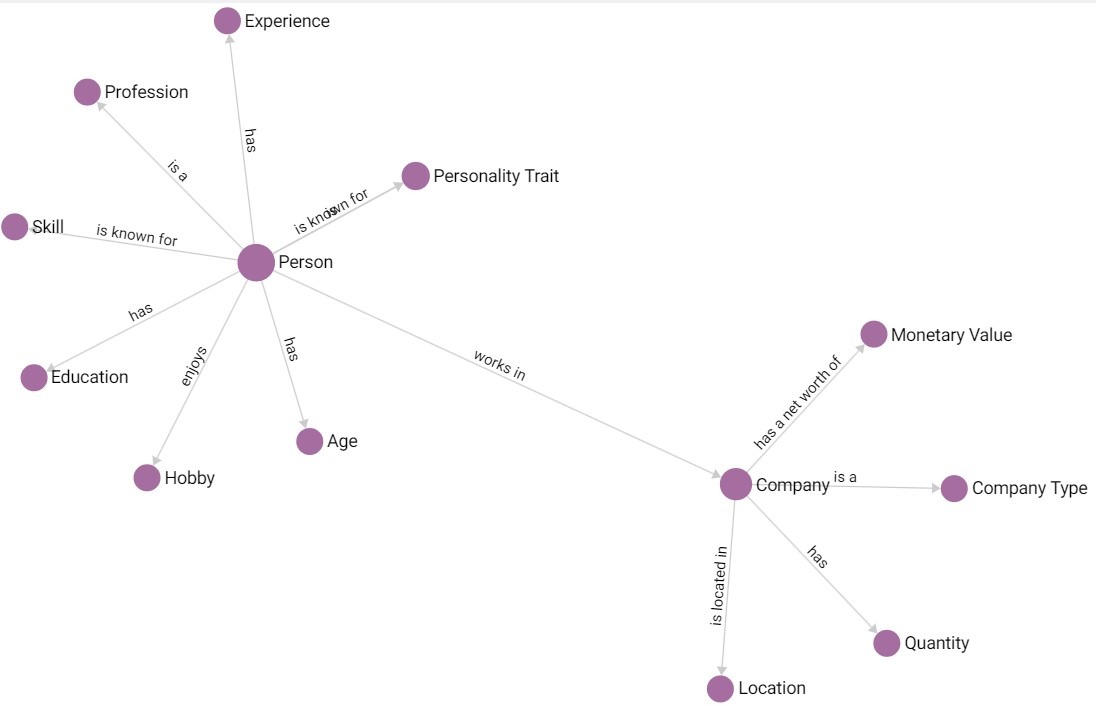
# final_ontology in numbers:
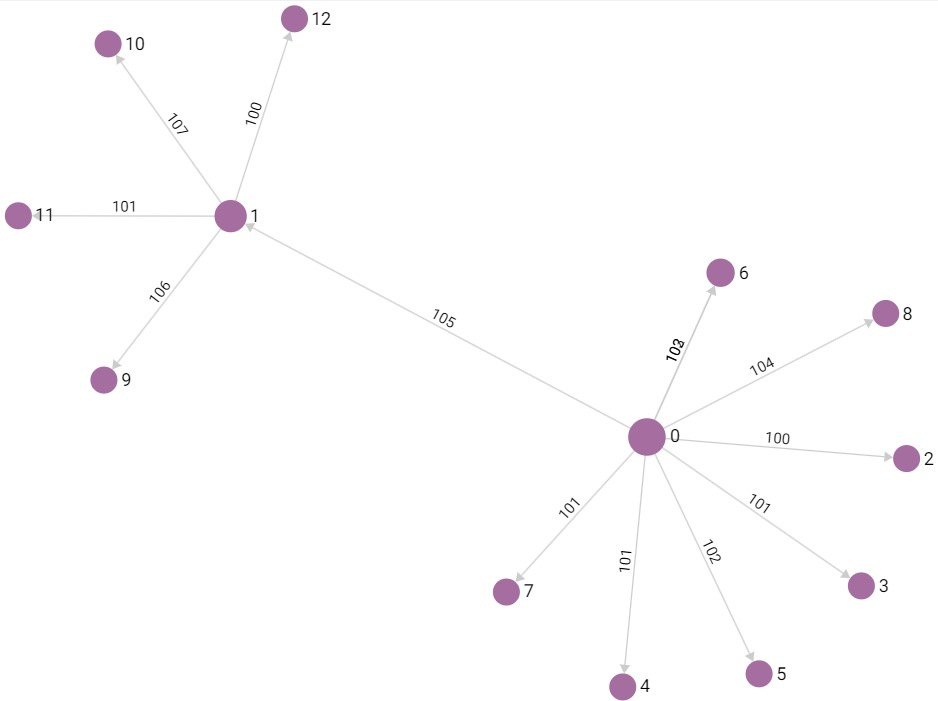

In [28]:
def translate_ontology(lang_name, lang_code):
    
    translator = Translator()

    # nodes
    for i in entities_onto_coll:
        translated_response = translator.translate(i["english"], dest=lang_code).text
        entities_onto_coll.update({"_key":i["_key"], lang_name:translated_response})

    # edges
    for i in relations_onto_coll:
        translated_response = translator.translate(i["english"], dest=lang_code).text
        relations_onto_coll.update({"_key":i["_key"], lang_name:translated_response})

In [30]:
translate_ontology("hindi","hi")
translate_ontology("Japanese", "ja")

# final_ontology in hindi:
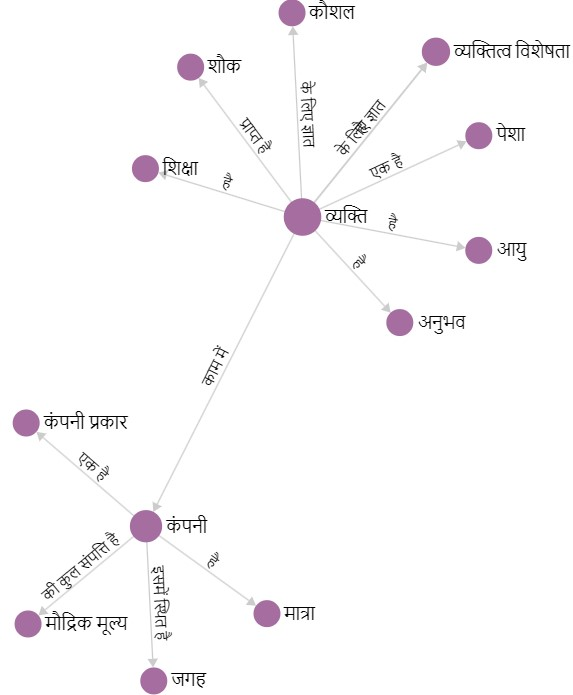

# final_ontology in japanese:
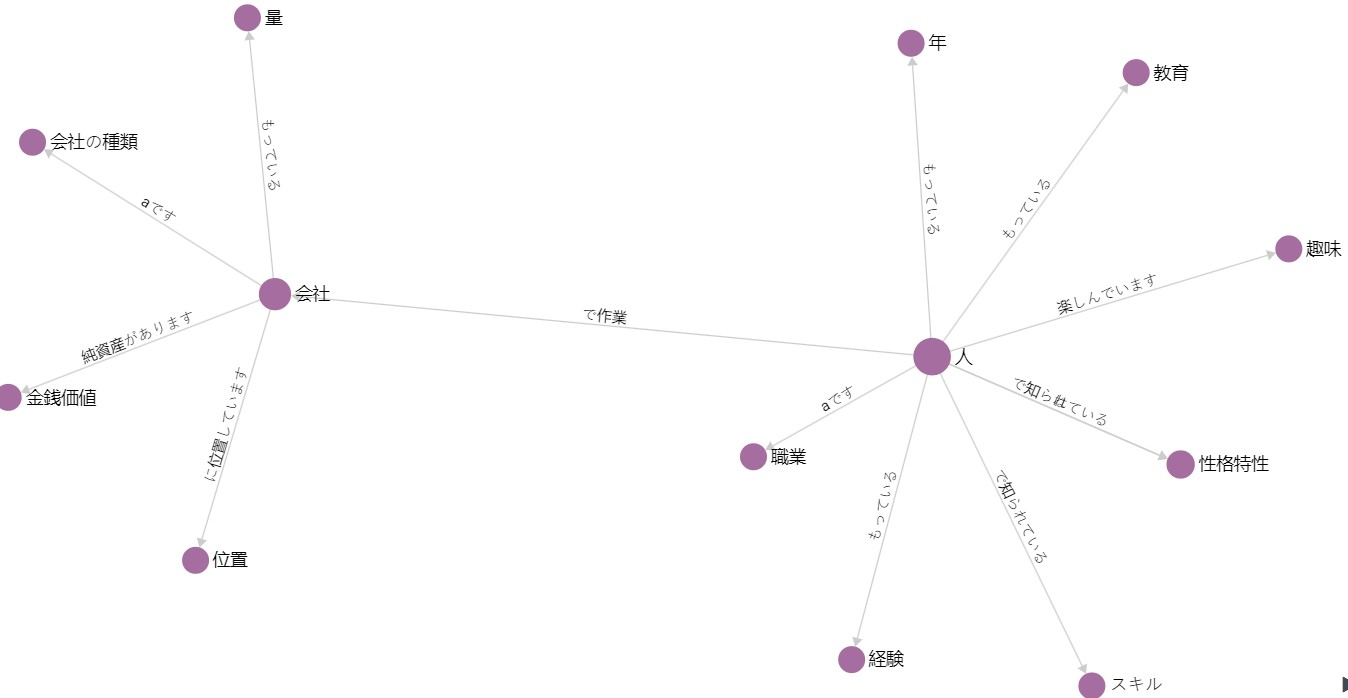

# By - Aryan Rathore, Reva Bharara